In [2]:
import cv2
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import torch
from sentence_transformers import SentenceTransformer

import sqlite3

from typing import Union, List, Dict

import warnings
warnings.filterwarnings("ignore")

c:\Users\Sergey\Desktop\QQQ\events_hack\цп_всеросс\new_venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
class Embedding:

    def __init__(self, name_db):
        self.model_name = 'clip-ViT-B-16'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.st_model = SentenceTransformer(self.model_name).to(self.device)
        self.name_db = name_db
        self.frames = None
        self.features = None

    def extract_features_from_array_vit(self, 
                                        frames):
        frames = [Image.fromarray(frame.astype('uint8'), 'RGB') for frame_idx, frame in frames]
        return self.st_model.encode(frames)
    
    def get_frames(self,
                   video_path, 
                   step_seconds):
        video = cv2.VideoCapture(video_path)
        fps = video.get(cv2.CAP_PROP_FPS)
        step_frames = int(fps * step_seconds)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        frames = []
        for frame_idx in tqdm(range(0, total_frames, step_frames)):
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            success, frame = video.read()
            if success:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = np.array(frame)
                frames.append((frame_idx, frame))
        video.release()
        
        return frames
    
    def get_embedding_frames(self,
                             frames):
        return self.extract_features_from_array_vit(frames)
    
    def get_embedding(self, 
                      video_path,
                      step_seconds):
        frames = self.get_frames(video_path, step_seconds)
        features = self.get_embedding_frames(frames)
        self.frames, self.features = frames, features

    def select_video_from_db(self,
                             name_db, 
                             video_name_for_db):
        conn = sqlite3.connect(f'dbs/{name_db}.db')
        cursor = conn.cursor()

        cursor.execute(f'SELECT * FROM base WHERE name_video = {video_name_for_db}')
        rows = cursor.fetchall()
        return rows

    def add_to_db(self, 
                  name_db, 
                  video_name_for_db):
        
        conn = sqlite3.connect(f'dbs/{name_db}.db')
        cursor = conn.cursor()

        feat_cols = [f'feat_{i}' for i in range(self.features.shape[1])]

        for (frame_idx, frame), features in zip(self.frames, self.features):
            command = f'INSERT INTO base (name_video, number_frame, {", ".join(feat_cols)}) '
            command += f'VALUES ({video_name_for_db}, {frame_idx}, {", ".join([str(feat) for feat in features])})'
            # print(command)
            cursor.execute(command)
            
        conn.commit()
        conn.close()

    def proccessing(self, 
                    video_path,
                    step_seconds,
                    video_name_for_db):
        if len(self.select_video_from_db(self.name_db, video_name_for_db)):
            print("Уже есть в базе")
            return None
        self.get_embedding(video_path, step_seconds)
        self.add_to_db(self.name_db, video_name_for_db)


In [4]:
video_dict = {
    'Silicon Valley S01E01.2014.KvK.BDRip.avi': '0',
    'Silicon Valley S06E01.2019.KvK.WEB-DLRip.avi': '1'
}
name_db = 'aaa'

In [5]:
emb = Embedding(name_db=name_db)

In [6]:
for video_name, video_name_for_db in tqdm(list(video_dict.items())):
    video_path = f'data/{video_name}'
    step_seconds = 1
    emb.proccessing(video_path, step_seconds, video_name_for_db)

  0%|          | 0/2 [00:00<?, ?it/s]

Уже есть в базе
Уже есть в базе


In [127]:
class Similar(Embedding):
    def __init__(self, name_db):
        super().__init__(name_db)

    def cosine_distance(self,
                        vec1, 
                        vec2):
        vec1 = np.array(vec1)
        vec2 = np.array(vec2)
        cosine_similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        return 1 - cosine_similarity

    def make_df_dist(self,
                     img_feat, 
                     frame_idx,
                     video_feats):
        list_dist = [self.cosine_distance(img_feat, frame_feat) for frame_feat in video_feats]
        list_dist = np.array(list_dist).flatten()
        df_dist = pd.DataFrame({
            'frame_idx': frame_idx,
            'dist': list_dist,
                                })
        df_dist = df_dist.sort_values('dist')
        return df_dist

    def get_similar(self,
                    img_path, 
                    frame_idx,
                    video_feats):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_feat = self.get_embedding_frames([(0, np.array(image))])[0]
        df_dist = self.make_df_dist(img_feat, frame_idx, video_feats)
        if df_dist.shape[0]:
            return df_dist
        else:
            return None
        

    def select_video_from_db(self,
                             name_db, 
                             video_name_for_db):
        conn = sqlite3.connect(f'dbs/{name_db}.db')
        cursor = conn.cursor()

        cursor.execute(f'SELECT * FROM base WHERE name_video = {video_name_for_db}')
        rows = cursor.fetchall()
        rows = np.array(rows)
        features = np.array(rows[:, 3:]).astype('float')
        frame_idx = np.array(rows[:, 2]).astype('float')
        return frame_idx, features
    
    def find_similar(self,
                     img_path,
                     video_name_for_db):
        frame_idx, features = self.select_video_from_db(self.name_db, video_name_for_db)
        df_dist = self.get_similar(img_path, frame_idx, features)
        self.df_dist = df_dist
        return df_dist
    
    def get_frame(self,
                  video_path, 
                  frame_idx):
        video = cv2.VideoCapture(video_path)
        if not video.isOpened():
            print("Ошибка: Не удалось открыть видео.")
            return None
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = video.read()
        if success:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            video.release()
            return frame
        video.release()
        
        
    def get_timings(self,
                    img_path,
                    video_path,
                    video_name_for_db,
                    seconds_delta=10):
        video = cv2.VideoCapture(video_path)
        fps = video.get(cv2.CAP_PROP_FPS)

        df_dist = self.find_similar(img_path, video_name_for_db)
        df_dist = df_dist[df_dist.dist < 0.3]

        if df_dist.shape[0] == 0:
            return None
        frames_idx, timings = [], []
        for frame_idx in sorted(df_dist.frame_idx):
            if not frames_idx or frame_idx - frames_idx[-1] >= seconds_delta * fps:
                frames_idx.append(frame_idx)

        timings = [idx // fps for idx in frames_idx]

        return frames_idx, timings
        

In [128]:
name_db = 'aaa'

In [129]:
s = Similar(name_db=name_db)

In [158]:
img_path = 'data/richard.jpg'
video_name, video_name_for_db = list(video_dict.items())[1]
video_path = f'data/{video_name}'
df_dist = s.find_similar(img_path, video_name_for_db)

In [159]:
frames_idx, timings = s.get_timings(img_path, video_path, video_name_for_db, 60)

In [160]:
# frames_idx, timings

In [161]:
def display_images(image_list, timings, cols=3):
    rows = (len(image_list) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows))
    axes = axes.flatten()

    for i, img in enumerate(image_list):
        if isinstance(img, np.ndarray):
            axes[i].imshow(img)
            axes[i].set_title(timings[i])
        else:
            print(f"Элемент {i} не является изображением.")
            axes[i].axis('off')

        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')\
        
    plt.tight_layout()
    plt.show()

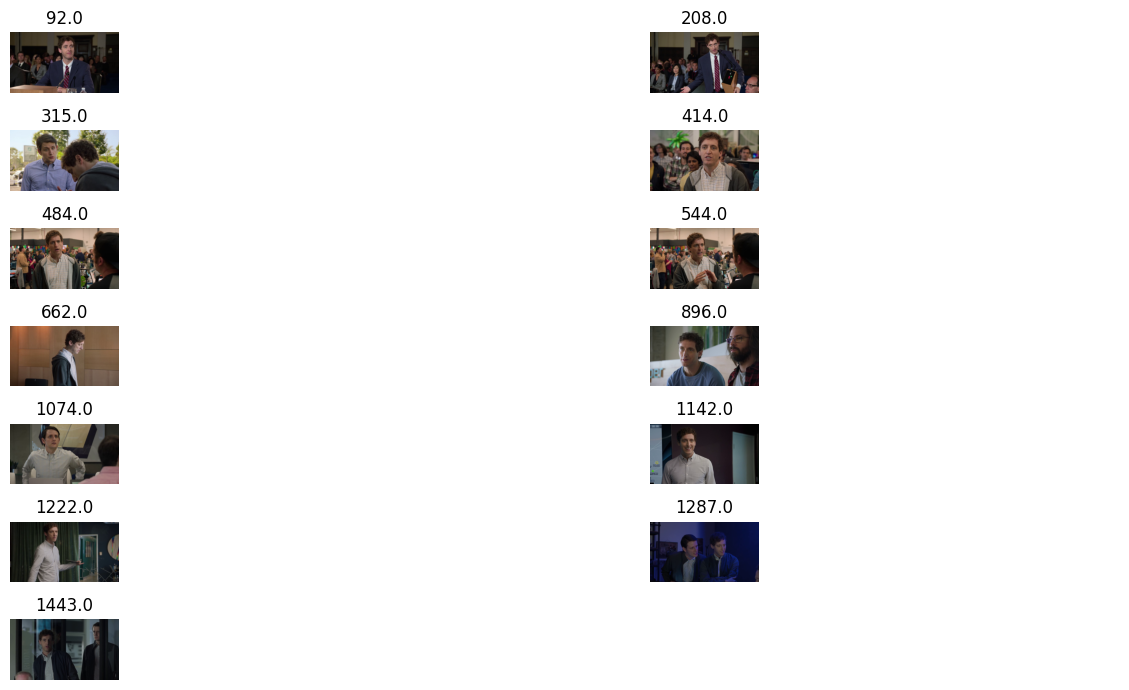

In [162]:
similar_photo = [s.get_frame(video_path, idx) for idx in frames_idx]
display_images(similar_photo, timings, 2)

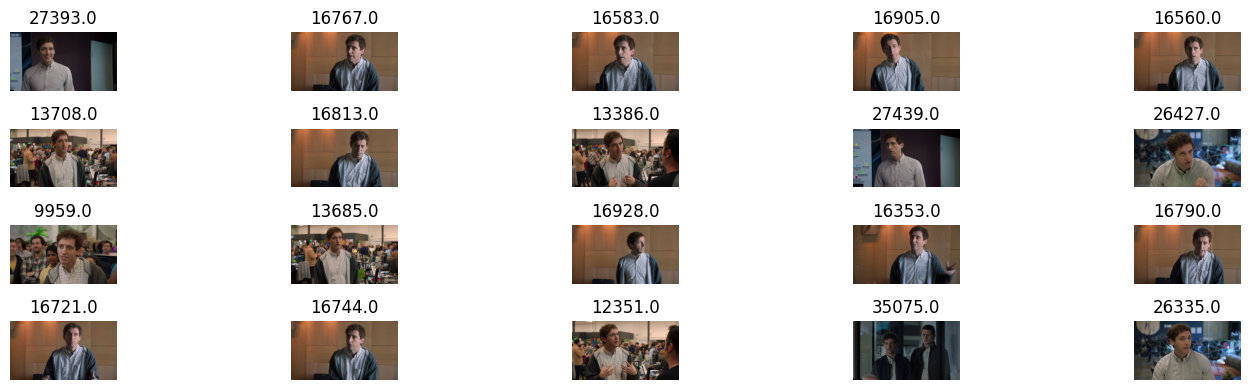

In [163]:
similar_photo = [s.get_frame(video_path, idx) for idx in df_dist.head(20).frame_idx]
display_images(similar_photo, df_dist.head(20).frame_idx.values, 5)